In [2]:
from tensorflow.keras import backend as K
K.clear_session()

2024-10-30 23:41:43.658044: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 23:41:43.815676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 23:41:43.879857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 23:41:43.897682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 23:41:44.010005: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import tensorflow as tf

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Optionally, list details about the available GPU devices
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1730311907.006504   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730311907.172403   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730311907.174588   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


train_dir = "/media/ritika/mydisk/ICDCIT/Diabetic Retinopathy/Dataset_split/train"
test_dir = "/media/ritika/mydisk/ICDCIT/Diabetic Retinopathy/Dataset_split/test"
val_dir = "/media/ritika/mydisk/ICDCIT/Diabetic Retinopathy/Dataset_split/validation"

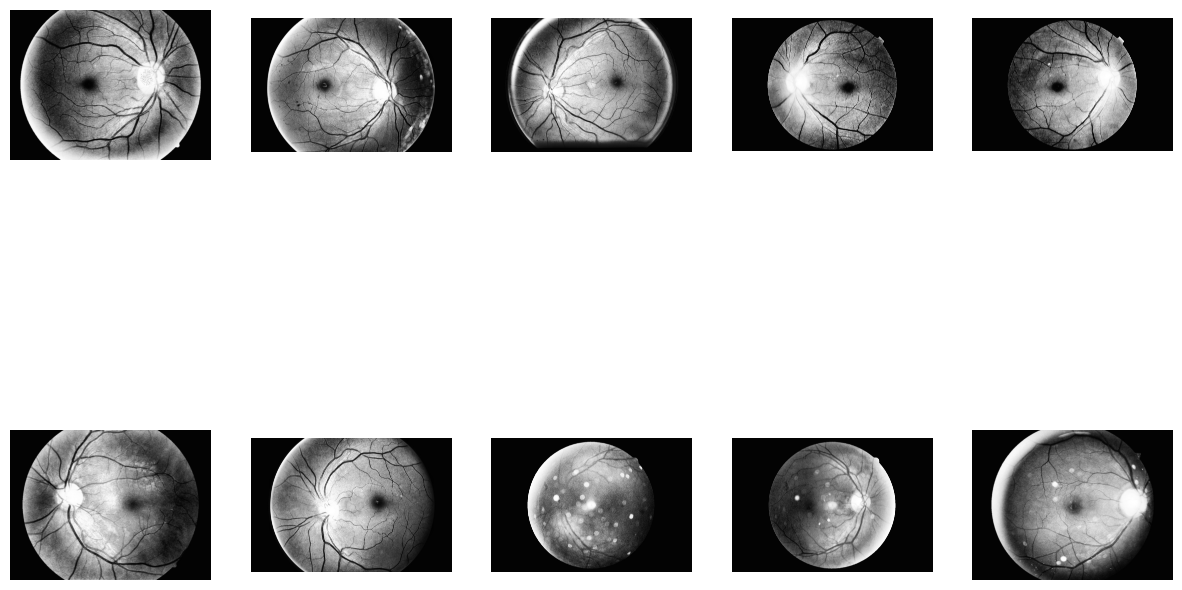

In [6]:
train_image_files = []
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        train_image_files.extend([os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith(('.png', '.jpg', '.jpeg'))])

# Load the first 10 images
images = [cv2.imread(file) for file in train_image_files[:10] if cv2.imread(file) is not None]

# Function to display images in a grid
def show_images(images, cols=5, rows=2):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            ax.imshow(img_rgb)
            ax.axis('off')  # Hide axes
    plt.show()

# Show the loaded images
show_images(images)

## Creating TFRecords for each directory

In [9]:
def serialize_example(image_string, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def create_tfrecord(data_dir, tfrecord_filename):
    class_names = sorted(os.listdir(data_dir))  # Ensure consistent class order
    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for label, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            for filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, filename)
                if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue  # Skip non-image files
                # Read and encode the image
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image_string = cv2.imencode('.jpg', image)[1].tobytes()  # Encode to JPEG
                example = serialize_example(image_string, label)
                writer.write(example)
    print(f'TFRecord created: {tfrecord_filename}')


create_tfrecord(train_dir, 'train.tfrecord')
create_tfrecord(val_dir, 'val.tfrecord')
create_tfrecord(test_dir, 'test.tfrecord')

TFRecord created: train.tfrecord
TFRecord created: val.tfrecord
TFRecord created: test.tfrecord


In [6]:
TARGET_SIZE = (512, 512)
BATCH_SIZE = 16

# function to augment data
# Step 2: Load TFRecord Files with Data Augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image

def parse_tfrecord_fn(example, apply_augmentation=False):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize to [0, 1]
    
    # Apply data augmentation only if specified
    if apply_augmentation:
        image = augment_image(image)

    label = tf.one_hot(example['label'], depth=len(os.listdir(train_dir)))  # One-hot encoding
    return image, label

def load_dataset(tfrecord_filenames, batch_size, shuffle=True, apply_augmentation=False):
    dataset = tf.data.TFRecordDataset(tfrecord_filenames)
    dataset = dataset.map(lambda x: parse_tfrecord_fn(x, apply_augmentation), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=1)
    return dataset

# Load datasets
train_dataset = load_dataset(['train.tfrecord'], BATCH_SIZE, apply_augmentation=True).repeat() # Apply augmentation to training set
val_dataset = load_dataset(['val.tfrecord'], BATCH_SIZE, shuffle=False, apply_augmentation=False)  # No augmentation
test_dataset = load_dataset(['test.tfrecord'], BATCH_SIZE, shuffle=False, apply_augmentation=False)  # No augmentation


I0000 00:00:1730311917.832722   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730311917.833833   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730311917.834732   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730311917.941781   70633 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
train_samples = count_samples('train.tfrecord')
val_samples = count_samples('val.tfrecord')

print(f'val_samples: {val_samples}')
print(f'train_samples: {train_samples}')



2024-10-30 23:42:26.447833: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


val_samples: 1770
train_samples: 10656


2024-10-30 23:42:31.154641: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
from collections import Counter

def calculate_class_weights(data_dir):
    class_counts = Counter()
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        num_samples = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[label] += num_samples
    
    # Total number of samples
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)
    
    # Calculate class weights
    class_weights = {i: total_samples / (num_classes * count) for i, count in class_counts.items()}
    
    return class_weights, class_counts

# Calculate class weights from the training directory
class_weights, class_counts = calculate_class_weights(train_dir)
print(f'Class weights: {class_weights}')


Class weights: {0: 0.5328, 1: 1.2122866894197952, 2: 0.5595169335783671, 3: 3.6060913705583757, 4: 4.279518072289156}


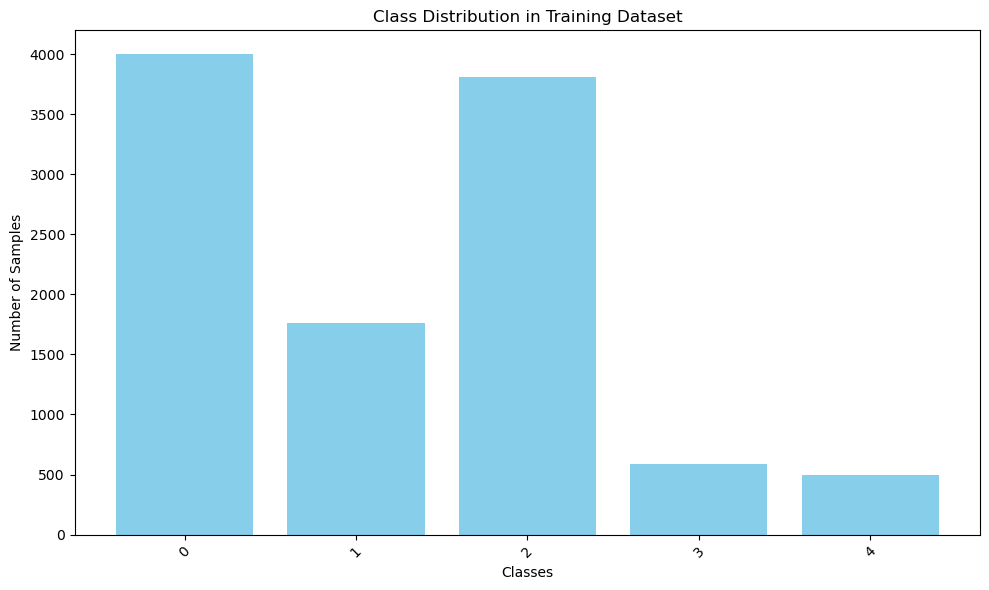

In [9]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    # Extract class names and counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(rotation=45)  # Rotate class labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Call the function with your class counts dictionary
plot_class_distribution(class_counts)


In [10]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

base_model =  EfficientNetB7(include_top=False, weights='imagenet', input_shape=(512,512,3))
base_model.trainable = True


2024-10-30 21:51:42.873181: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 130s 1us/step


In [11]:
print(f"NUmber of layers in the model: {len(base_model.layers)}")

NUmber of layers in the model: 814


In [12]:
for layer in base_model.layers[:-10]:  
    layer.trainable = False


In [13]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',kernel_initializer=he_normal(), kernel_regularizer=l2(0.001))(x)  
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_initializer=he_normal(), kernel_regularizer=l2(0.001))(x)  
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 512, 512,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 512, 512,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 513, 513,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 256, 256,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 256, 256,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 256, 256,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 256, 256,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 256, 256,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 256, 256,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 256, 256,  │          0 │ block1a_activati

 Total params: 64,788,380 (247.15 MB)

 Trainable params: 6,025,125 (22.98 MB)

 Non-trainable params: 58,763,255 (224.16 MB)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
    ]
)

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Optional

class SimpleMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, every_n_epochs: int = 10, save_plots: bool = False, plot_path: str = 'accuracy_loss_plot.png'):
        super().__init__()
        self.every_n_epochs = every_n_epochs
        self.save_plots = save_plots
        self.plot_path = plot_path
        self.history = {
            'epochs': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }

    def on_epoch_end(self, epoch: int, logs: Optional[dict] = None) -> None:
        """Store accuracy and loss at the end of each epoch."""
        if logs is None:
            logs = {}
            
        # Append accuracy and loss to history
        self.history['epochs'].append(epoch + 1)
        self.history['train_accuracy'].append(logs.get('accuracy', 0))
        self.history['val_accuracy'].append(logs.get('val_accuracy', 0))
        self.history['train_loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        
        # Log the results for this epoch
        tf.print(f'Epoch {epoch + 1}: Train Accuracy: {logs.get("accuracy", 0):.4f}, Val Accuracy: {logs.get("val_accuracy", 0):.4f}, '
                 f'Train Loss: {logs.get("loss", 0):.4f}, Val Loss: {logs.get("val_loss", 0):.4f}')
        
        # Plot the metrics every n epochs or at the last epoch
        if (epoch + 1) % self.every_n_epochs == 0 or epoch == self.params['epochs'] - 1:
            self.plot_metrics()

    def plot_metrics(self) -> None:
        """Plot accuracy and loss over epochs."""
        try:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Plot accuracy
            axes[0].plot(self.history['epochs'], self.history['train_accuracy'], label='Train Accuracy', marker='o')
            axes[0].plot(self.history['epochs'], self.history['val_accuracy'], label='Val Accuracy', marker='o')
            axes[0].set_title('Accuracy over Epochs')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True)

            # Plot loss
            axes[1].plot(self.history['epochs'], self.history['train_loss'], label='Train Loss', marker='o')
            axes[1].plot(self.history['epochs'], self.history['val_loss'], label='Val Loss', marker='o')
            axes[1].set_title('Loss over Epochs')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            
            # Save or show the plot
            if self.save_plots:
                plt.savefig(self.plot_path)
                plt.close()
            else:
                plt.show()
                
        except Exception as e:
            tf.print(f"Error plotting metrics: {str(e)}")


In [17]:
history = model.fit(
    train_dataset,
    steps_per_epoch= train_samples//BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps= val_samples//BATCH_SIZE,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5


2024-10-30 21:54:48.959513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 50332032 bytes after encountering the first element of size 50332032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1730305488.980652   63176 service.cc:146] XLA service 0x7c774c003300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730305488.980704   63176 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-30 21:54:51.001320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 21:54:54.206506: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-30 21:55:15.245369: E external/local_

666/666 ━━━━━━━━━━━━━━━━━━━━ 260s 293ms/step - accuracy: 0.4632 - auc: 0.7342 - loss: 1.7241 - precision: 0.5081 - recall: 0.3386 - val_accuracy: 0.0398 - val_auc: 0.2159 - val_loss: 3.0591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 164s 246ms/step - accuracy: 0.2507 - auc: 0.5256 - loss: 1.6123 - precision: 0.2618 - recall: 0.0589 - val_accuracy: 0.1000 - val_auc: 0.7862 - val_loss: 1.5924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5


2024-10-30 22:01:29.311230: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/ritika/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


666/666 ━━━━━━━━━━━━━━━━━━━━ 173s 260ms/step - accuracy: 0.2457 - auc: 0.5262 - loss: 1.3775 - precision: 0.2579 - recall: 0.0292 - val_accuracy: 0.0267 - val_auc: 0.2045 - val_loss: 2.5738 - val_precision: 0.0185 - val_recall: 5.6818e-04
Epoch 4/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 149s 224ms/step - accuracy: 0.2938 - auc: 0.5498 - loss: 1.2936 - precision: 0.4048 - recall: 0.0530 - val_accuracy: 0.0000e+00 - val_auc: 0.7500 - val_loss: 1.3700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 173s 260ms/step - accuracy: 0.3335 - auc: 0.5761 - loss: 1.2757 - precision: 0.4734 - recall: 0.1053 - val_accuracy: 0.0273 - val_auc: 0.2317 - val_loss: 3.2436 - val_precision: 0.0318 - val_recall: 0.0193


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EfficientNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=True)

# history = model.fit(
#     train_dataset,
#     steps_per_epoch= train_samples//BATCH_SIZE,
#     validation_data=val_dataset,
#     validation_steps= val_samples//BATCH_SIZE,
#     epochs=100,
#     class_weight=class_weights,
#     callbacks=[model_checkpoint, reduce_lr, callback]
# )

NameError: name 'EarlyStopping' is not defined

Epoch 11/50


2024-10-30 23:43:44.148181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 50331968 bytes after encountering the first element of size 50331968 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1730312024.160738   70801 service.cc:146] XLA service 0x70e2dc016c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730312024.160777   70801 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-30 23:43:45.169065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 23:43:48.890311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-30 23:44:09.144728: E external/local_

666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5417 - auc: 0.7482 - loss: 1.4784 - precision: 0.6736 - recall: 0.3943
Epoch 11: val_loss improved from inf to 2.12595, saving model to EfficientNet_model.keras
Epoch 11: Train Accuracy: 0.5938, Val Accuracy: 0.2409, Train Loss: 1.3127, Val Loss: 2.1259
666/666 ━━━━━━━━━━━━━━━━━━━━ 277s 321ms/step - accuracy: 0.5418 - auc: 0.7483 - loss: 1.4782 - precision: 0.6737 - recall: 0.3943 - val_accuracy: 0.2409 - val_auc: 0.3124 - val_loss: 2.1259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 12/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.6166 - auc: 0.8075 - loss: 1.1884 - precision: 0.7275 - recall: 0.4436

2024-10-30 23:50:51.943492: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/ritika/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 12: val_loss improved from 2.12595 to 2.03306, saving model to EfficientNet_model.keras
Epoch 12: Train Accuracy: 0.6482, Val Accuracy: 0.0000, Train Loss: 1.1381, Val Loss: 2.0331
666/666 ━━━━━━━━━━━━━━━━━━━━ 178s 267ms/step - accuracy: 0.6166 - auc: 0.8076 - loss: 1.1883 - precision: 0.7275 - recall: 0.4437 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_loss: 2.0331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 13/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.6244 - auc: 0.8237 - loss: 1.1371 - precision: 0.7439 - recall: 0.4518
Epoch 13: val_loss did not improve from 2.03306
Epoch 13: Train Accuracy: 0.6517, Val Accuracy: 0.2409, Train Loss: 1.1129, Val Loss: 2.0921
666/666 ━━━━━━━━━━━━━━━━━━━━ 180s 270ms/step - accuracy: 0.6245 - auc: 0.8238 - loss: 1.1371 - precision: 0.7439 - recall: 0.4519 - val_accuracy: 0.2409 - val_auc: 0.3126 - val_loss: 2.0921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 

2024-10-30 23:56:31.639022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-30 23:56:31.640020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282



Epoch 14: val_loss improved from 2.03306 to 1.81882, saving model to EfficientNet_model.keras
Epoch 14: Train Accuracy: 0.6544, Val Accuracy: 0.0000, Train Loss: 1.1012, Val Loss: 1.8188
666/666 ━━━━━━━━━━━━━━━━━━━━ 161s 242ms/step - accuracy: 0.6276 - auc: 0.8259 - loss: 1.1282 - precision: 0.7539 - recall: 0.4521 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_loss: 1.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 15/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6279 - auc: 0.8190 - loss: 1.1412 - precision: 0.7412 - recall: 0.4321
Epoch 15: val_loss did not improve from 1.81882
Epoch 15: Train Accuracy: 0.6526, Val Accuracy: 0.2409, Train Loss: 1.0973, Val Loss: 2.0837


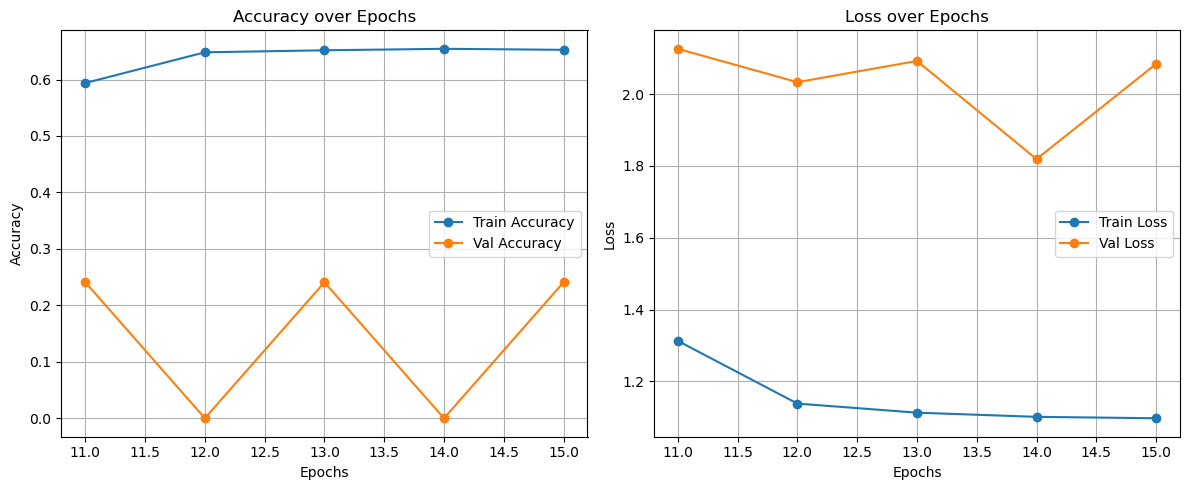

666/666 ━━━━━━━━━━━━━━━━━━━━ 176s 265ms/step - accuracy: 0.6279 - auc: 0.8191 - loss: 1.1411 - precision: 0.7412 - recall: 0.4322 - val_accuracy: 0.2409 - val_auc: 0.3134 - val_loss: 2.0837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 16/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6159 - auc: 0.8150 - loss: 1.1496 - precision: 0.7349 - recall: 0.4111
Epoch 16: val_loss did not improve from 1.81882
Epoch 16: Train Accuracy: 0.6465, Val Accuracy: 0.0000, Train Loss: 1.0957, Val Loss: 1.8212
666/666 ━━━━━━━━━━━━━━━━━━━━ 157s 235ms/step - accuracy: 0.6159 - auc: 0.8150 - loss: 1.1495 - precision: 0.7349 - recall: 0.4112 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_loss: 1.8212 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 17/50


2024-10-31 00:02:09.601842: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-31 00:02:09.602516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:02:09.602610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6135 - auc: 0.8119 - loss: 1.1636 - precision: 0.7153 - recall: 0.3989
Epoch 17: val_loss did not improve from 1.81882

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 17: Train Accuracy: 0.6418, Val Accuracy: 0.2409, Train Loss: 1.0944, Val Loss: 2.1310
666/666 ━━━━━━━━━━━━━━━━━━━━ 204s 302ms/step - accuracy: 0.6135 - auc: 0.8119 - loss: 1.1634 - precision: 0.7153 - recall: 0.3990 - val_accuracy: 0.2409 - val_auc: 0.3104 - val_loss: 2.1310 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 18/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1768 - auc: 0.4423 - loss: 1.8484 - precision: 0.1161 - recall: 9.5371e-04
Epoch 18: val_loss did not improve from 1.81882
Epoch 18: Train Accuracy: 0.3498, Val Accuracy: 0.0000, Train Loss: 1.6134, Val Loss: 2.2184
666/666 ━━━━━━━━━━━━━━━━━━━━ 154s 231ms/step - accuracy: 0.1770 - auc: 0.4425 - loss: 1.8481 - preci

2024-10-31 00:08:07.950731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:08:07.951385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2714 - auc: 0.7569 - loss: 1.4241 - precision: 0.1650 - recall: 0.0037
Epoch 19: val_loss improved from 1.81882 to 1.44441, saving model to EfficientNet_model.keras
Epoch 19: Train Accuracy: 0.3864, Val Accuracy: 0.2409, Train Loss: 1.4371, Val Loss: 1.4444
666/666 ━━━━━━━━━━━━━━━━━━━━ 213s 315ms/step - accuracy: 0.2715 - auc: 0.7569 - loss: 1.4241 - precision: 0.1654 - recall: 0.0038 - val_accuracy: 0.2409 - val_auc: 0.7422 - val_loss: 1.4444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 20/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3108 - auc: 0.7808 - loss: 1.3150 - precision: 0.2392 - recall: 0.0116
Epoch 20: val_loss did not improve from 1.44441
Epoch 20: Train Accuracy: 0.4017, Val Accuracy: 0.0000, Train Loss: 1.3936, Val Loss: 2.8180


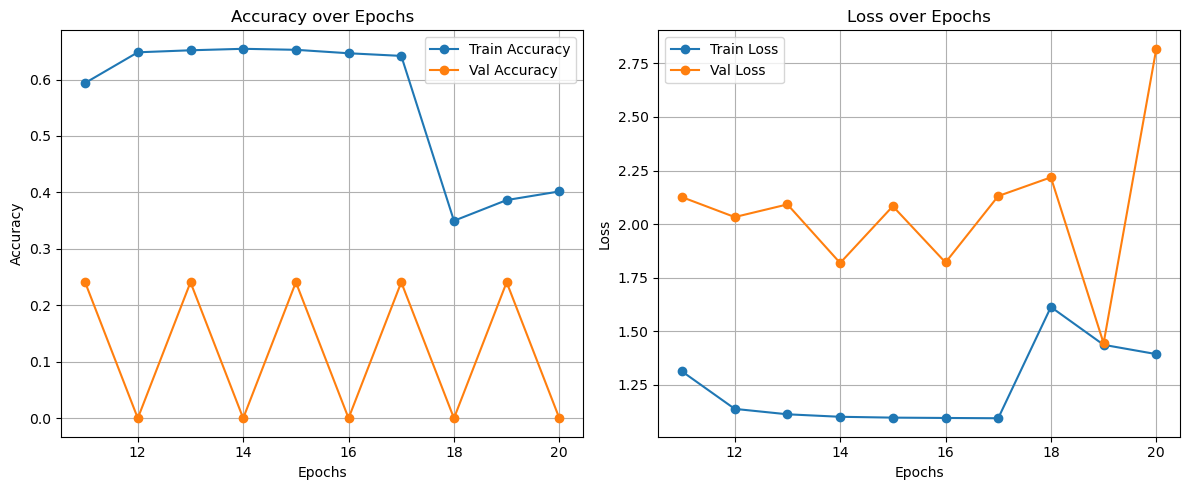

666/666 ━━━━━━━━━━━━━━━━━━━━ 153s 230ms/step - accuracy: 0.3109 - auc: 0.7807 - loss: 1.3152 - precision: 0.2395 - recall: 0.0116 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 2.8180 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 21/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3211 - auc: 0.7854 - loss: 1.2780 - precision: 0.2376 - recall: 0.0167
Epoch 21: val_loss improved from 1.44441 to 1.40894, saving model to EfficientNet_model.keras
Epoch 21: Train Accuracy: 0.4090, Val Accuracy: 0.2409, Train Loss: 1.3777, Val Loss: 1.4089
666/666 ━━━━━━━━━━━━━━━━━━━━ 183s 270ms/step - accuracy: 0.3213 - auc: 0.7854 - loss: 1.2781 - precision: 0.2378 - recall: 0.0167 - val_accuracy: 0.2409 - val_auc: 0.7424 - val_loss: 1.4089 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 22/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.3195 - auc: 0.7863 - loss: 1.2575 - precision: 0.2530 

2024-10-31 00:25:44.791347: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3272 - auc: 0.7871 - loss: 1.2370 - precision: 0.1527 - recall: 0.0063
Epoch 25: val_loss improved from 1.39234 to 1.36497, saving model to EfficientNet_model.keras
Epoch 25: Train Accuracy: 0.4083, Val Accuracy: 0.2409, Train Loss: 1.3638, Val Loss: 1.3650


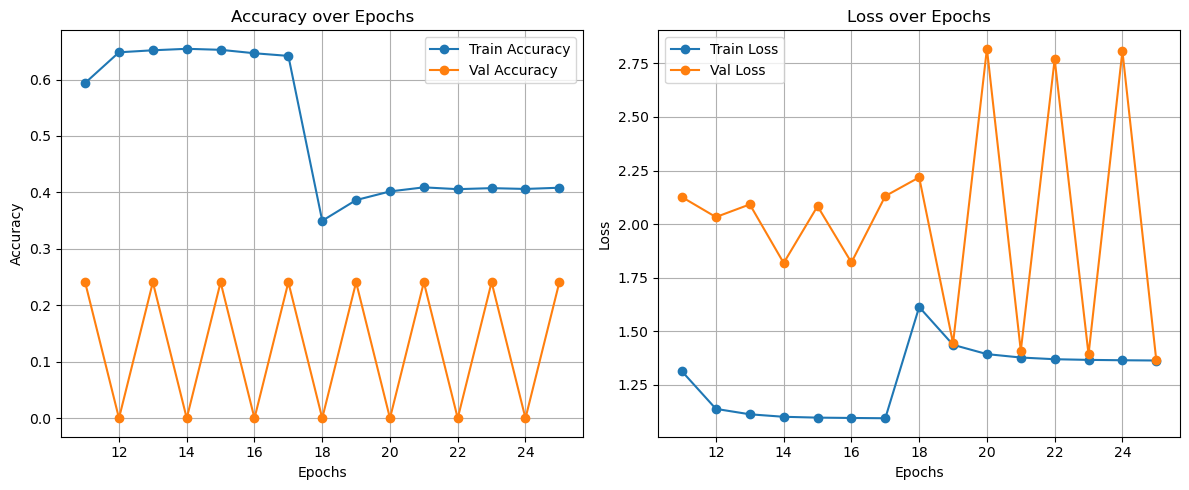

666/666 ━━━━━━━━━━━━━━━━━━━━ 183s 270ms/step - accuracy: 0.3273 - auc: 0.7870 - loss: 1.2372 - precision: 0.1531 - recall: 0.0063 - val_accuracy: 0.2409 - val_auc: 0.7434 - val_loss: 1.3650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 26/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3250 - auc: 0.7873 - loss: 1.2334 - precision: 0.1698 - recall: 0.0052
Epoch 26: val_loss did not improve from 1.36497
Epoch 26: Train Accuracy: 0.4054, Val Accuracy: 0.0000, Train Loss: 1.3651, Val Loss: 2.7535
666/666 ━━━━━━━━━━━━━━━━━━━━ 153s 230ms/step - accuracy: 0.3251 - auc: 0.7873 - loss: 1.2336 - precision: 0.1702 - recall: 0.0053 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 2.7535 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 27/50


2024-10-31 00:31:20.875207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:31:20.876943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3337 - auc: 0.7880 - loss: 1.2299 - precision: 0.1380 - recall: 0.0040
Epoch 27: val_loss improved from 1.36497 to 1.35114, saving model to EfficientNet_model.keras
Epoch 27: Train Accuracy: 0.4051, Val Accuracy: 0.2409, Train Loss: 1.3632, Val Loss: 1.3511
666/666 ━━━━━━━━━━━━━━━━━━━━ 184s 272ms/step - accuracy: 0.3338 - auc: 0.7880 - loss: 1.2301 - precision: 0.1384 - recall: 0.0041 - val_accuracy: 0.2409 - val_auc: 0.7414 - val_loss: 1.3511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 28/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3368 - auc: 0.7904 - loss: 1.2233 - precision: 0.1800 - recall: 0.0052
Epoch 28: val_loss did not improve from 1.35114
Epoch 28: Train Accuracy: 0.4089, Val Accuracy: 0.0000, Train Loss: 1.3592, Val Loss: 2.6765
666/666 ━━━━━━━━━━━━━━━━━━━━ 153s 230ms/step - accuracy: 0.3369 - auc: 0.7903 - loss: 1.2235 - precision: 0.1803 - recall: 0.0052 - v

2024-10-31 00:36:58.083515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:36:58.084399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3394 - auc: 0.7894 - loss: 1.2236 - precision: 0.1118 - recall: 0.0030
Epoch 29: val_loss did not improve from 1.35114
Epoch 29: Train Accuracy: 0.4017, Val Accuracy: 0.2409, Train Loss: 1.3621, Val Loss: 1.3643
666/666 ━━━━━━━━━━━━━━━━━━━━ 191s 283ms/step - accuracy: 0.3394 - auc: 0.7893 - loss: 1.2239 - precision: 0.1122 - recall: 0.0030 - val_accuracy: 0.2409 - val_auc: 0.7423 - val_loss: 1.3643 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 30/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3385 - auc: 0.7904 - loss: 1.2184 - precision: 0.1018 - recall: 0.0026
Epoch 30: val_loss did not improve from 1.35114

Epoch 30: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 30: Train Accuracy: 0.3991, Val Accuracy: 0.0000, Train Loss: 1.3615, Val Loss: 2.8275


2024-10-31 00:42:42.600018: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:42:42.600839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


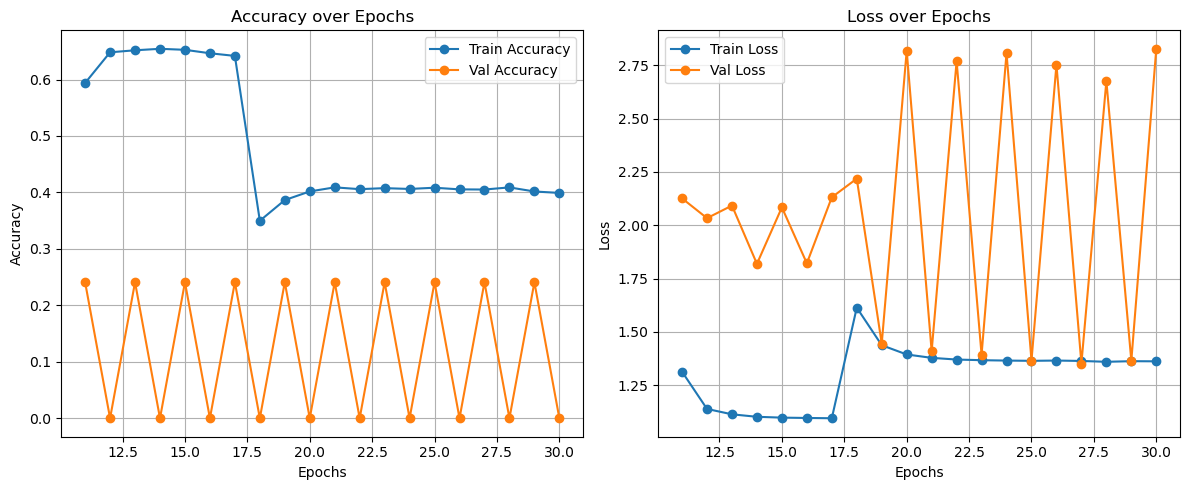

666/666 ━━━━━━━━━━━━━━━━━━━━ 154s 231ms/step - accuracy: 0.3386 - auc: 0.7903 - loss: 1.2186 - precision: 0.1022 - recall: 0.0026 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 2.8275 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 31/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.1320 - auc: 0.7351 - loss: 1.3159 - precision: 0.0546 - recall: 0.0017
Epoch 31: val_loss improved from 1.35114 to 1.32691, saving model to EfficientNet_model.keras
Epoch 31: Train Accuracy: 0.3519, Val Accuracy: 0.2409, Train Loss: 1.3810, Val Loss: 1.3269
666/666 ━━━━━━━━━━━━━━━━━━━━ 199s 295ms/step - accuracy: 0.1323 - auc: 0.7351 - loss: 1.3160 - precision: 0.0549 - recall: 0.0017 - val_accuracy: 0.2409 - val_auc: 0.7426 - val_loss: 1.3269 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 32/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.1391 - auc: 0.7365 - loss: 1.2770 - precision: 0.0577 

2024-10-31 00:48:34.530808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:48:34.531819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1483 - auc: 0.7393 - loss: 1.2504 - precision: 0.0661 - recall: 2.0386e-04
Epoch 33: val_loss improved from 1.32691 to 1.28796, saving model to EfficientNet_model.keras
Epoch 33: Train Accuracy: 0.3486, Val Accuracy: 0.2409, Train Loss: 1.3655, Val Loss: 1.2880
666/666 ━━━━━━━━━━━━━━━━━━━━ 183s 270ms/step - accuracy: 0.1486 - auc: 0.7393 - loss: 1.2506 - precision: 0.0665 - recall: 2.0524e-04 - val_accuracy: 0.2409 - val_auc: 0.7429 - val_loss: 1.2880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 34/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1729 - auc: 0.7435 - loss: 1.2310 - precision: 0.0510 - recall: 7.6763e-05
Epoch 34: val_loss did not improve from 1.28796
Epoch 34: Train Accuracy: 0.3468, Val Accuracy: 0.0000, Train Loss: 1.3633, Val Loss: 2.8364
666/666 ━━━━━━━━━━━━━━━━━━━━ 153s 230ms/step - accuracy: 0.1732 - auc: 0.7434 - loss: 1.2312 - precision: 0.0514 - recall

2024-10-31 00:54:10.649703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 00:54:10.650641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1948 - auc: 0.7496 - loss: 1.2145 - precision: 0.0456 - recall: 2.4374e-05
Epoch 35: val_loss improved from 1.28796 to 1.27419, saving model to EfficientNet_model.keras
Epoch 35: Train Accuracy: 0.3475, Val Accuracy: 0.2409, Train Loss: 1.3608, Val Loss: 1.2742


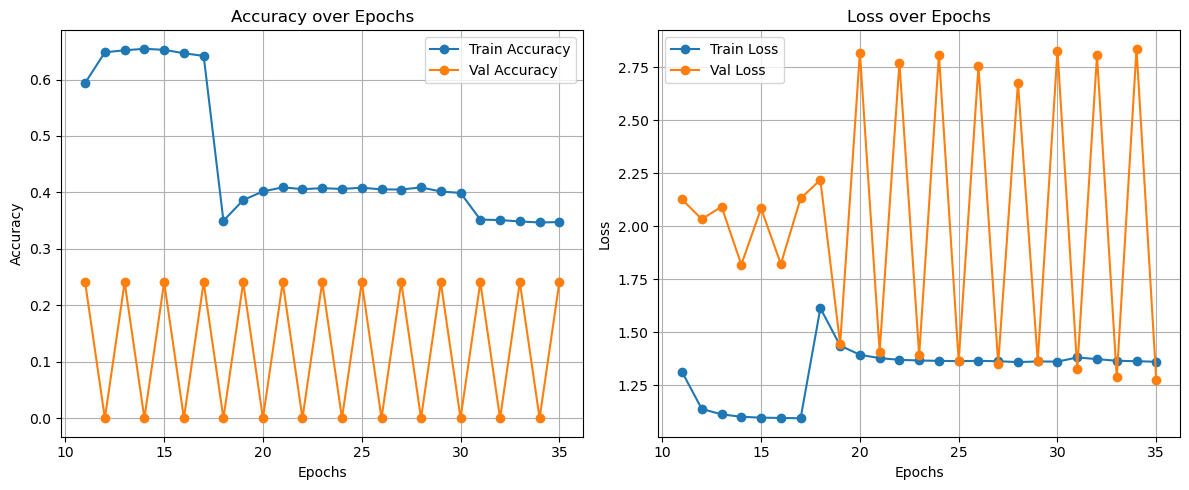

666/666 ━━━━━━━━━━━━━━━━━━━━ 185s 273ms/step - accuracy: 0.1950 - auc: 0.7496 - loss: 1.2147 - precision: 0.0459 - recall: 2.4619e-05 - val_accuracy: 0.2409 - val_auc: 0.7424 - val_loss: 1.2742 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 36/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.2217 - auc: 0.7568 - loss: 1.2026 - precision: 0.0048 - recall: 2.2803e-06
Epoch 36: val_loss did not improve from 1.27419
Epoch 36: Train Accuracy: 0.3479, Val Accuracy: 0.0000, Train Loss: 1.3563, Val Loss: 2.8481
666/666 ━━━━━━━━━━━━━━━━━━━━ 153s 229ms/step - accuracy: 0.2219 - auc: 0.7568 - loss: 1.2029 - precision: 0.0050 - recall: 2.4176e-06 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 2.8481 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 37/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.2401 - auc: 0.7629 - loss: 1.1938 - precision: 0.0238 - recall: 1.2000e-05
Epoch 37: val

2024-10-31 01:10:59.502908: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


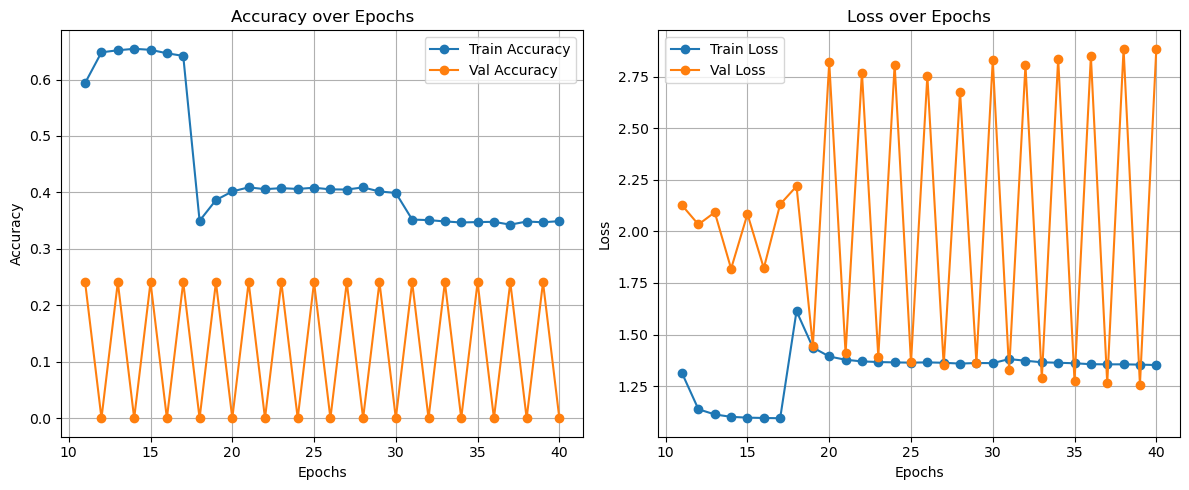

666/666 ━━━━━━━━━━━━━━━━━━━━ 154s 231ms/step - accuracy: 0.3177 - auc: 0.7841 - loss: 1.1706 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 2.8812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 41/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3402 - auc: 0.7889 - loss: 1.1676 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 41: val_loss improved from 1.25653 to 1.25029, saving model to EfficientNet_model.keras
Epoch 41: Train Accuracy: 0.3554, Val Accuracy: 0.2409, Train Loss: 1.3529, Val Loss: 1.2503
666/666 ━━━━━━━━━━━━━━━━━━━━ 182s 268ms/step - accuracy: 0.3402 - auc: 0.7888 - loss: 1.1678 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2409 - val_auc: 0.7431 - val_loss: 1.2503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 42/50
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3540 - auc: 0.7935 - loss: 1.1

2024-10-31 01:16:34.825351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12329791890178834744
2024-10-31 01:16:34.826243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2659999958489797282


666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3793 - auc: 0.7984 - loss: 1.1582 - precision: 0.1321 - recall: 1.3288e-05
Epoch 43: val_loss improved from 1.25029 to 1.24888, saving model to EfficientNet_model.keras
Epoch 43: Train Accuracy: 0.3647, Val Accuracy: 0.2409, Train Loss: 1.3485, Val Loss: 1.2489
666/666 ━━━━━━━━━━━━━━━━━━━━ 191s 281ms/step - accuracy: 0.3793 - auc: 0.7983 - loss: 1.1584 - precision: 0.1334 - recall: 1.3409e-05 - val_accuracy: 0.2409 - val_auc: 0.7427 - val_loss: 1.2489 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-05
Epoch 44/50
166/666 ━━━━━━━━━━━━━━━━━━━━ 2:00 240ms/step - accuracy: 0.3085 - auc: 0.8199 - loss: 1.0524 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

In [15]:
from tensorflow.keras.models import load_model
model = load_model('/media/ritika/mydisk/ICDCIT/Diabetic Retinopathy/Diabetic-Retinopathy/EfficientNet_model.keras')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EfficientNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5)

model.optimizer.lr = 0.00001

history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples//BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples//BATCH_SIZE,
    epochs=50,            
    initial_epoch=10,     
    callbacks=[early_stopping, model_checkpoint, reduce_lr,custom_metrics_callback]
)
